In [1]:
import src.acquire
import src.prepare
import src.explore
import src.model

In [2]:
path='zillow_df.csv'

df, X_train_explore, \
    X_train_scaled, y_train, \
    X_validate_scaled, y_validate, \
    X_test_scaled, y_test = src.prepare.wrangle_zillow(path)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((12217, 12), (5236, 12), (4364, 12))

In [5]:
X_train_explore.shape

(12217, 16)

In [6]:
X_train_explore

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplace,garage,hottub_spa,lotsizesquarefeet,poolcnt,roomcnt,taxvaluedollarcnt,zip,useid,year,zip_cc,useid_cc,year_cc
4948,0.0,0.0,2676.0,0.0,0.0,0.0,4666.0,0.0,0.0,309966.0,96961.0,248.0,1972.0,288,2,85
20098,2.0,3.0,2559.0,0.0,0.0,0.0,14969.0,0.0,0.0,316925.0,96424.0,261.0,1950.0,228,4,63
3086,2.0,4.0,2118.0,0.0,2.0,0.0,7700.0,1.0,9.0,212814.0,96218.0,261.0,1959.0,137,4,72
9484,1.0,3.0,1590.0,0.0,0.0,0.0,7443.0,0.0,0.0,477113.0,96486.0,261.0,1921.0,251,4,34
18735,2.0,6.0,1948.0,0.0,0.0,0.0,4981.0,0.0,0.0,103299.0,96117.0,261.0,1952.0,83,4,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12963,3.0,4.0,3204.0,0.0,2.0,1.0,9750.0,1.0,0.0,1024984.0,96971.0,261.0,1989.0,296,4,102
15010,2.5,3.0,1492.0,0.0,2.0,0.0,3600.0,0.0,0.0,352440.0,96974.0,261.0,1989.0,298,4,102
5751,3.0,3.0,2003.0,0.0,0.0,0.0,199789.0,1.0,0.0,1648488.0,96116.0,261.0,1975.0,82,4,88
13660,2.0,3.0,1571.0,0.0,0.0,0.0,6780.0,0.0,0.0,88385.0,96101.0,261.0,1962.0,71,4,75


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# Explore

MVP- 3 Features
1. calculatedfinishedsquarefeet
2. bedroomcnt
3. bathroomcnt

Target = taxvaluedollarcnt

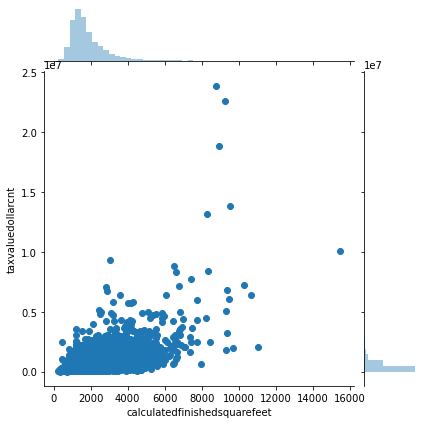

In [8]:
# Visualize relationship between square feet and tax value (Continuous and Continuous)
sns.jointplot(x='calculatedfinishedsquarefeet',y='taxvaluedollarcnt', data=X_train_explore)
plt.show()

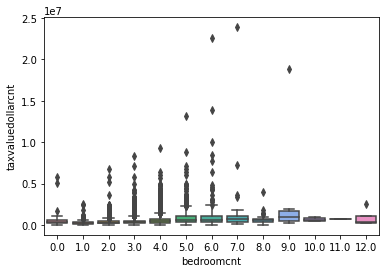

In [9]:
# Visualize relationship between bedroom count and tax value (Continuous and Categorical)
X_train_explore['bedroom_bin'] = pd.cut(X_train_explore.bedroomcnt, bins=[0, 3, 6, 9, 12], labels=['3', '6', '9', '12'])
sns.boxplot(data=X_train_explore, y='taxvaluedollarcnt', x='bedroomcnt')
plt.show()

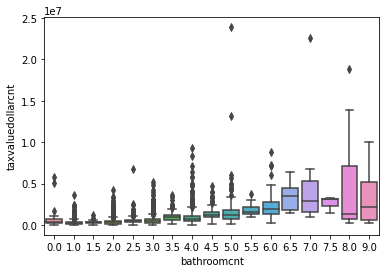

In [10]:
# Visualize relationship between bathroom count and tax value (Continuous and Categorical)
X_train_explore['bathroom_bin'] = pd.cut(X_train_explore.bathroomcnt, bins=[0, 3, 6, 9], labels=['3', '6', '9'])
sns.boxplot(data=X_train_explore, y='taxvaluedollarcnt', x='bathroomcnt')
plt.show()

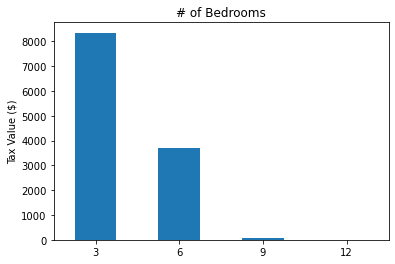

In [11]:
# Histogram of Bedrooms
X_train_explore.bedroom_bin.value_counts().sort_index().plot.bar()
plt.title('# of Bedrooms')
plt.ylabel('Tax Value ($)')
plt.xticks(rotation=0)
plt.show()

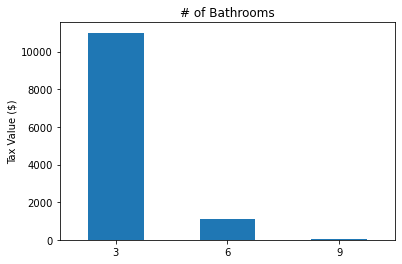

In [12]:
# Histogram of Bedrooms
X_train_explore.bathroom_bin.value_counts().sort_index().plot.bar()
plt.title('# of Bathrooms')
plt.ylabel('Tax Value ($)')
plt.xticks(rotation=0)
plt.show()

In [13]:
# Categorical and Categorical

ctab = pd.crosstab(train.exam1_letter_grade, train.classroom, normalize=True)
sns.heatmap(ctab, cmap='Purples', annot=True, fmt='.1%')



NameError: name 'train' is not defined

#### Takeaway:

1. The only feature that appears to correlate wth the target in a linear fashion is calculatedfinishedsqure feet
2. Most housese have 3 or less bathrooms
3. Most houses have 3 or less bedrooms
4. Bathroom data has a lot more variance then bedroom data

## Evaluate Linear Features

In [ ]:
# This is the code for the Linear Model
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression, SelectKBest, RFE 

In [ ]:
# Evaluate squre feet
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ calculatedfinishedsquarefeet', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.calculatedfinishedsquarefeet)

In [ ]:
# Evaluate bedroom count
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ bedroomcnt', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.bedroomcnt)

In [ ]:
# Evaluate bathroom count

src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ bathroomcnt', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.bathroomcnt)

### Takaway:

- All 3 Variables pass F-test and are significant to use in our modeling

***

## Hypothesis Testing

***

#### Chi Squared Test For Independence:

**Hypothesis: There is a relationship between # of bedrooms and # of bathrooms that would make them a good canidate for future feature engeneering.**

Null Hypothesis: $H_{0}$: Number of Bedrooms and Number of Bathrooms are independent

Alternative Hypothesis: $H_{a}$: Number of Bedrooms and Number of Bathrooms are dependent


In [ ]:
# Hypothesis Test

alpha = 0.05
contingency_table = pd.crosstab(X_train_explore.bedroomcnt, X_train_explore.bathroomcnt)

chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

if p < alpha:
    print("We reject the null hypothesis")
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
else:
    print("We fail to reject the null hypothesis")

#### Takeaway:

- Num. of bathrooms and Num. of bedrooms are related, and most likely would make an effective combined feature

***

***

# Modeling

Creating 4 Models to run on train dataset
1. Linear Regression
2. LassoLars
3. Polynomial Features
4. TweedieRegressor

In [ ]:
# Models
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

### Create a Baseline

In [ ]:
# Mean Value
np.mean(y_train)
y_train.shape

In [ ]:
# encode as variable
# np.full modiefies shape turns value in to a full series object
baseline_rmse = mean_squared_error(y_train, np.full(12224, np.mean(y_train)))**(1/2)
baseline_rmse  # Model Error To Beat $665,000

***

# Train

***

### Linear Regression

In [ ]:
# Make Model
lm = LinearRegression(normalize=True)
# Fit Model
lm.fit(X_train_scaled, y_train)
# Make Predictions
lm_pred = lm.predict(X_train_scaled)
# Compute root mean squared error
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
lm_rmse

### LassoLars

In [ ]:
# Make a model
lars = LassoLars(alpha=1)
# Fit a model
lars.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred = lars.predict(X_train_scaled)
# Computer root mean squared error
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
lars_rmse

### Ploynomial Features

In [ ]:
# Make a model
pf = PolynomialFeatures(degree=2)

# Fit and Transform model
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)

# Feed new features in to linear model. 
lm_squared = LinearRegression()
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute root mean squared error
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

### Tweedie Regressor

In [ ]:
# Make Model
tw = TweedieRegressor(power=0, alpha=0.1) # 0 = normal distribution
# Fit Model
tw.fit(X_train_scaled, y_train)
# Make Predictions
tw_pred = tw.predict(X_train_scaled)
# Compute root mean squared error
tw_rmse = mean_squared_error(y_train, tw_pred)**(1/2)
tw_rmse

***

### Takeaway:
- Top 3 preforming models are Linear, LassoLars, and Polynomial
- These modes will move on to Validate

***

# Validate

### Linear Regression

In [ ]:
# Make Predictions
lm_pred_v = lm.predict(X_validate_scaled)
# Compute root mean squared error
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
lm_rmse_v

### LassoLars

In [ ]:
# Make predictions
lars_pred_v = lars.predict(X_validate_scaled)
# Compute root mean squared error
lars_rmse_v = mean_squared_error(y_validate, lars_pred_v)**(1/2)
lars_rmse_v

### Ploynomial Features

In [ ]:
# Make predictions
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
# Compute root mean squared error
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
lm_squared_rmse_v

***

### Takeaway:
- On unseen data Linear and  LassoLars preformed the test, error decreases indicates no overfitting
- Polynomial model error skyrocketed, indicates overfitt
- Evaluate LassoLars on Test

***

# Test

### LassoLars

In [ ]:
# Make Predictions (On best Model)
lars_pred_test = lars.predict(X_test_scaled)
# Compute root mean squared error
lars_rmse_test = mean_squared_error(y_test, lars_pred_test)**(1/2)
lars_rmse_test

***

### Takeaway:
- LassoLars is 

***